In [81]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# for data scaling and splitting
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# for neural net
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# for evaluation
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, validation_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
seed = 0
np.random.seed(seed)


In [82]:
data = pd.read_csv("data/combined_expression.csv")
#Defining the positive and negative response clusters
data['cluster'].replace([1, 2],[0, 1],inplace=True) 
data.head()
data.shape

(541, 16384)

In [83]:
#Feature Selection done via Buruta
selected_genes = pd.read_csv('cleaned/boruta.csv')
selected_genes = selected_genes.values.tolist()
selected_genes = list(itertools.chain(*selected_genes))
len(selected_genes)

300

In [84]:
# retrieving proper columns
X = data.loc[:, selected_genes]
y = data['cluster'].values
# scaling the data
scalar = MinMaxScaler()
x_scaled = scalar.fit_transform(X)
# splitting data (20% test, 80% train)
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2)
#SMOTE oversampling to combat uneven classes
sm = SMOTE()
X_train, y_train = sm.fit_sample(X_train, y_train)
X_train.shape



(570, 300)

In [85]:
#def create_model(optimizer='adagrad',init='normal'):
model = Sequential()
    # adding layers and adding droplayers to avoid overfitting
hidden_layers = len(selected_genes)

model.add(Dense(hidden_layers*2, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(hidden_layers*4, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(hidden_layers*4, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(hidden_layers*2, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))
    # compiling
model.compile(optimizer='adagrad', loss='binary_crossentropy', metrics=['accuracy'])
#return model

In [115]:
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)
cvscores = []
history = []
tprs_cv = []
base_fpr_cv = np.linspace(0, 1, 101)
for train, test in kfold.split(X_train, y_train):
	# Fit the model
	model_cv = model.fit(X_train[train], y_train[train],validation_set=(X_train[test],y_train[test]), epochs=50,batch_size=32,verbose=1)
	results_fold = model_cv.history
	results_fold.append(history)
	# roc and auc
	y_score = model.predict_proba(X_train[test])
	fpr_cv, tpr_cv, _ = roc_curve(y_train[test], y_score[:, 1])
	tpr_cv = np.interp(base_fpr_cv, fpr_cv, tpr_cv)
	tpr_cv[0] = 0.0
	tprs_cv.append(tpr_cv)
	# evaluate the model
	scores = model.evaluate( X_train[test], y_train[test], verbose=0)
	print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
	cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/50
285/285 [==============================] - 0s 2ms/sample - loss: 0.0097 - acc: 0.9965
Epoch 2/50
285/285 [==============================] - 0s 2ms/sample - loss: 0.0145 - acc: 0.9965
Epoch 3/50
285/285 [==============================] - 0s 2ms/sample - loss: 0.0048 - acc: 1.0000
Epoch 4/50
285/285 [==============================] - 0s 2ms/sample - loss: 0.0063 - acc: 0.9965
Epoch 5/50
285/285 [==============================] - 1s 2ms/sample - loss: 0.0024 - acc: 1.0000
Epoch 6/50
285/285 [==============================] - 0s 2ms/sample - loss: 0.0049 - acc: 1.0000
Epoch 7/50
285/285 [==============================] - 0s 2ms/sample - loss: 0.0126 - acc: 0.9965
Epoch 8/50
285/285 [==============================] - 0s 1ms/sample - loss: 0.0021 - acc: 1.0000
Epoch 9/50
285/285 [==============================] - 0s 1ms/sample - loss: 0.0075 - acc: 0.9965
Epoch 10/50
285/285 [==============================] - 0s 1ms/sample - loss: 0.0111 - acc: 0.9965
Epoch 11/50
285/285 [========

In [ ]:
plt.plot(hostory.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.ylim(0, 1)
plt.show()

In [116]:
scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

109/109 [==============================] - 0s 592us/sample - loss: 0.7303 - acc: 0.8257
acc: 82.57%


In [122]:
base_fpr_model = np.linspace(0, 1, 101)
y_prediction = model.predict(X_test).ravel()
fpr_model, tpr_model, thresholds_model = roc_curve(y_test,y_prediction)
tpr_model = np.array(tpr_model)
auc_model = (base_fpr_model,tpr_model)


In [123]:
# for 4 hidden layers
tprs_cv = np.array(tprs_cv)
mean_tprs_cv = tprs_cv.mean(axis=0)
std_cv = tprs_cv.std(axis=0)
tprs_upper = np.minimum(mean_tprs_cv + std_cv, 1)
tprs_lower = mean_tprs_cv - std_cv
auc_cv = auc(base_fpr, mean_tprs_cv)

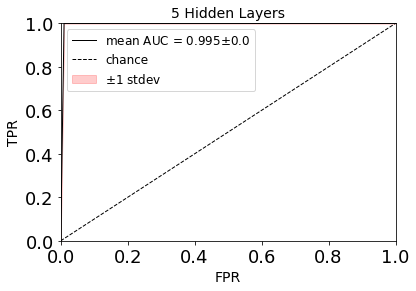

In [125]:
plt.plot(base_fpr_cv, mean_tprs_cv, color='k', linewidth=1)
#plt.plot(base_fpr_model, tpr_model,color='r',linewidth=1)
plt.fill_between(base_fpr_cv, tprs_lower, tprs_upper, alpha=0.2, color='r')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('5 Hidden Layers', fontsize=14)
plt.ylabel('TPR', fontsize=14)
plt.xlabel('FPR', fontsize=14)
plt.legend(['mean AUC = ' + str(round(auc_cv, 3)) + '$\pm$' + str(round(np.mean(std_cv), 3)), 'chance', '$\pm1$ stdev'],
           fontsize=12)

plt.show()

In [1]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True, cbar=True):
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names, rotation=90, verticalalignment='center')
#         plt.yticks([], ['', ''])

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    if cbar:
        plt.colorbar()

    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted\naccuracy={:0.3f}; misclass={:0.3f}'.format(accuracy, misclass))
    plt.show()